##Lab 8 - Training a Regression Model to Predict House Price using Boston Housing Dataset##

Date: 22 November 2023

Problem Statement: Build and Train a Neural Network based Regression Model to predict the
median price of houses in a given Boston suburb. Use The Boston Housing Price dataset for the
purpose. The dataset contains house prices for houses from Boston suburb in the 1970s. Since
the dataset size is relatively very less, use K-fold cross validation during the training phase. Apply
appropriate feature scaling before inputting the data to the model. Finally evaluate the model on
Test data and use the resulting trained and evaluated model to do the predictions on some data.

Step 1 - Data Exploration and Pre-processing

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [2]:
train_data.shape
test_data.shape

(102, 13)

In [3]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [4]:
#feature selection
mean=train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Step 2 - Build your network

Since we have less data we should build a relatively small model, say only with two hidden layers with 64 units per layer.

In [5]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=["mae"])
  return model

Step 3 - Validating the model using K-fold cross validation

If we use a single fold cross validation, we will have to split training data into a training set and a
validation set. But because we have very few datapoints (only 404), the validation set will have
too less data points (may be less than 100). Thus, validation scores can be misleading varying
with each sample you chose for training and validation.
The best practice in such case is to use K-fold cross validation and then use the avergage
validation of the k iterations. This is more reliable

In [6]:
import numpy as np

k = 5
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print(f"Processing fold number: {i}")
  val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
  partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i+1) * num_val_samples:]],
    axis=0)
  partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i+1) * num_val_samples:]],
    axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

Processing fold number: 0
Processing fold number: 1
Processing fold number: 2
Processing fold number: 3
Processing fold number: 4


In [7]:
all_scores
np.mean(all_scores)

2.3773757219314575

Increasing the number of epochs and capturing and saving the per epoch validation scores for each fold
We will try to train the network a bit longer: for 500 epochs. To keep a record of how well the model does at each epoch, we will modify the training loop to save the per epoch validation socre loss

In [8]:
num_epochs = 500
all_mae_history = []
for i in range(k) :
  print(f"Processing fold #{i}")
  val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i+1) * num_val_samples:]],
    axis=0)
  partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i+1) * num_val_samples:]],
    axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=16, verbose=0)
  mae_history = history.history["val_mae"]
  all_mae_history.append(mae_history)

Processing fold #0


Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


Calculating the average of per epoch MAE score We will build a history of successive mean K-fold validation scores per epoch.

In [9]:
average_mae_history = [
np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

Text(0, 0.5, 'Validation MAE')

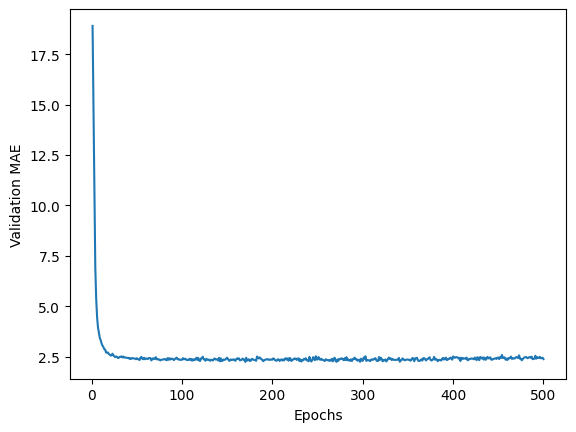

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")

Text(0, 0.5, 'Validation MAE')

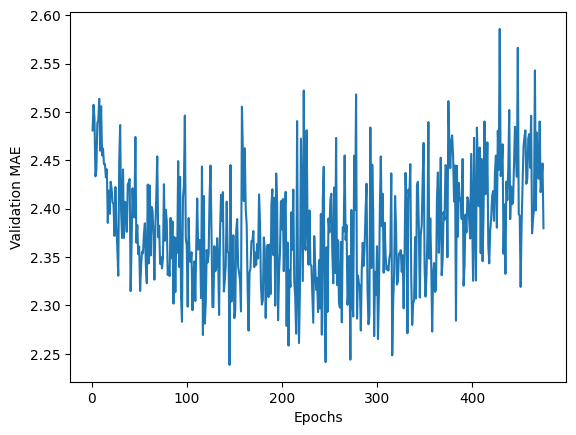

In [11]:
truncated_mae_history = average_mae_history[25:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")

Step 4: Training the final model from scratch with all the
original training data

In [12]:
model = build_model()
model.fit(train_data, train_targets, epochs=150, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 16.0834 - mae: 2.6397


2.639737367630005

Step 5: Generating predictions on new data

In [13]:
predictions = model.predict(test_data)
predictions[5]

test_targets[5]

4/4 [==============================] - 0s 3ms/step


24.5